In [1]:
import pandas as pd
import numpy as np
import requests
import os
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

<ipython-input-1-fbc5e49cd709>:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def df_from_ticker(ticker):
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=1483228800&period2=1767225600&interval=1d&events=history&includeAdjustedClose=true"
    print("Fetching data for " + ticker)
    headers = {"User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36"}
    response = requests.get(url, headers=headers)
    with open("temp.csv", "wb") as f:
        f.write(response.content)
    df = pd.read_csv("temp.csv")
    os.remove("temp.csv")  # Remove the temporary CSV file
    return df.reset_index(drop=True)

In [3]:
# Find common dates across all DataFrames
def preprocess_dfs(tickers):
    raw_dfs = [df_from_ticker(ticker) for ticker in tickers]
    print("Done.")
    common_dates = set(raw_dfs[0]["Date"])
    for df in raw_dfs[1:]:
        common_dates.intersection_update(df["Date"])

    # Sort the common dates in descending order
    common_dates = sorted(common_dates)
    print("Using " + str(len(common_dates)) + " days.")
    print("Until " + common_dates[-1] + ".")

    # Filter DataFrames to keep only common dates
    filtered_dfs = []
    for j, df in enumerate(raw_dfs):
        i = 0
        while (i < df.shape[0]):
            if df["Date"].iloc[i] not in common_dates:
                df = df.iloc[list(set(range(df.shape[0])) - set([i]))]
            else:
                i += 1
        df = df.reset_index(drop=True)
        filtered_dfs.append(df[["High", "Low", "Close", "Volume"]])
    for i, df in enumerate(filtered_dfs):
        filtered_dfs[i] = np.log(df)

    for i, df in enumerate(filtered_dfs):
        df.columns = [tickers[i] + '_' + col if col != 'Date' else col for col in df.columns]

    # Concatenate all dfs
    concatenated_df = pd.concat(filtered_dfs, axis = 1)
    print("Using {} features.".format(concatenated_df.shape[1]))
    return(concatenated_df)

In [4]:
def get_training_data(preprocessed, filt, decay_constant=0.33):
    n = preprocessed.shape[0]
    Y = np.zeros((n, len(filt)))
    Y_vectors = preprocessed[[ticker + "_Close" for ticker in filt]]
    Y[n-1,] = Y_vectors.iloc[n-1]
    for i in range(n - 2, -1, -1):
        Y[i,] = (1-decay_constant)*Y_vectors.iloc[i+1] + decay_constant*Y[i+1,]
    # drop the last observation
    Y = Y[:-1,] - Y_vectors.drop(index=n-1)
    X = preprocessed.drop(index=n-1)
    n -= 1
    
    print("Training on X: " + str(X.shape))
    print("Training on Y: " + str(Y.shape))
    return (X, Y)

def normalize(X, Y=None):
    X_means = np.mean(X, axis=0)
    X_stds = np.std(X, axis=0)
    X_normalized = (X - X_means) / X_stds
    if Y is None:
        return X_normalized
    Y_means = np.mean(Y, axis=0)
    Y_normalized = Y - Y_means
    return (X_normalized, Y_normalized)

In [5]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [6]:
class PortfolioBuilder(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layers=1):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        
        self.h1 = nn.Linear(n_input, n_input)
        self.h2 = nn.Linear(n_input, n_input)
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers)
        self.out = nn.Linear(n_hidden, n_output)
        
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x, hidden):
        x = self.dropout(self.h1(x))
        x = self.dropout(torch.tanh(self.h2(x)))
        x, hidden = self.lstm(x.unsqueeze(0), hidden)
        if len(x.shape) == 3:
            x = x.squeeze(0)
        x = F.softmax(self.out(x), dim=1)
        return(x, hidden)
    
    def init_hidden(self, batch_size=1):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data # match the datatype
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        return hidden if batch_size > 1 else tuple([h.view(self.n_layers, self.n_hidden) for h in hidden])

def returns(portfolio, log_changes, sharpe=False):
    if len(portfolio.shape) == 1:
        portfolio = portfolio.unsqueeze(0)
        log_changes = log_changes.unsqueeze(0)
    if sharpe:
        Sigma = torch.Tensor(np.array(Y.cov()))
        aSigmaa = (torch.matmul(portfolio[:,:-1], Sigma) * portfolio[:,:-1]).sum(axis=1)
        neg_loss_sharpe = -((portfolio[:,:-1] * log_changes).sum(axis=1)/torch.sqrt(aSigmaa)).mean()
        return(neg_loss_sharpe)
    else:
        neg_loss = -(portfolio[:,:-1] * log_changes).sum(axis=1).mean()
        return(neg_loss)

In [7]:
def train(X, Y, n_epochs, batch_size=10, lr=0.001, clip=5, test_size=0.2, file=None):
    start_at = X.shape[0] - batch_size * (X.shape[0]//batch_size)
    all_indices = np.array(range(start_at, X.shape[0]))
    all_indices = all_indices.reshape(batch_size,-1)
    n = all_indices.shape[1]
    use_for_test = [False if i/n < 1- test_size else True for i in range(n)]
    
    optimizer = torch.optim.Adam(rnn.parameters(), lr = lr)
    
    min_test_loss = float("inf")
    all_losses = []
    for epoch in range(n_epochs):
#         np.random.shuffle(train_indices)
        hidden = rnn.init_hidden(batch_size)
        train_loss = 0
        test_loss = 0
        for i in range(n):
            inds = all_indices[:,i]
            if use_for_test[i]:
                rnn.eval()
            else:
                rnn.train()
                optimizer.zero_grad()
                
            x = torch.Tensor(np.array(X.iloc[inds])).to(torch.float32)
            y = torch.Tensor(np.array(Y.iloc[inds])).to(torch.float32)
                

            prediction, hidden = rnn(x, hidden)
            hidden = tuple([h.data for h in hidden])
#             print(hidden)
            loss = criterion(prediction, y)
    
            if use_for_test[i]:
                test_loss += loss
            else:
                loss.backward()
                nn.utils.clip_grad_norm_(rnn.parameters(), clip)
                optimizer.step()
                train_loss += loss
        train_loss = train_loss.item() / (n - np.sum(use_for_test))
        test_loss = test_loss.item() / np.sum(use_for_test)
        all_losses.append((train_loss, test_loss))
        if epoch % 10 == 9:
            print("Epochs: " + str(epoch+1))
            print("Train / Test loss: " + "{:.6f}".format(train_loss) + " / {:.6f}".format(test_loss))
        if test_loss < min_test_loss and file is not None:
            print("Saving at epoch {}. Test loss of {}.".format(epoch+1, test_loss))
            min_test_loss = test_loss
            torch.save({'model_state_dict': rnn.state_dict(),
                        'loss': test_loss}, file)

    plt.plot(list(range(n_epochs)), [loss[0] for loss in all_losses])
    plt.plot(list(range(n_epochs)), [loss[1] for loss in all_losses])

In [8]:
tickers = ["META", "IBM", "GOOG", "MSFT", "NVDA", "SPY", "INTC", "TSLA", "BTC-USD"]  # Example list of stock codes
filt = ["IBM", "NVDA", "GOOG"] # the stocks to include in the portfolio

preprocessed = preprocess_dfs(tickers)
model_file = 'model.pth'

Fetching data for META
Fetching data for IBM
Fetching data for GOOG
Fetching data for MSFT
Fetching data for NVDA
Fetching data for SPY
Fetching data for INTC
Fetching data for TSLA
Fetching data for BTC-USD
Done.
Using 1794 days.
Until 2024-02-20.
Using 36 features.


In [9]:
rnn = PortfolioBuilder(preprocessed.shape[1], len(filt) + 1, len(filt))
print(rnn)

new_model = False # train a new model?
if new_model:
    X, Y = get_training_data(preprocessed, filt, decay_constant=0.33)
    X, Y = normalize(X, Y)

    sharpe = False # use the sharpe ratio or maximize profits?
    criterion = lambda predicted, target: returns(predicted, target, sharpe)

    train(X, Y, n_epochs=120, batch_size=10, test_size=0.2, file=model_file)

PortfolioBuilder(
  (h1): Linear(in_features=36, out_features=36, bias=True)
  (h2): Linear(in_features=36, out_features=36, bias=True)
  (lstm): LSTM(36, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


Using all 1794 days.
Total assets: 3700 EUR
Averages: {'IBM': 731.9387734858191, 'NVDA': 970.2797648646266, 'GOOG': 959.1906892681865, 'CASH': 1038.590770261268}
Portfolio: {'IBM': 6.907069, 'NVDA': 15.363761, 'GOOG': 32.618393, 'CASH': 3645.1108}


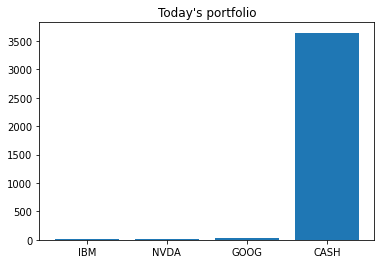

In [10]:
if model_file is not None:
    checkpoint = torch.load(model_file)
    rnn.load_state_dict(checkpoint['model_state_dict'])
    
hidden = rnn.init_hidden()

X = normalize(preprocessed)
n = X.shape[0]
print("Using all {} days.".format(n))

all_predictions = np.zeros(len(filt)+1)
for i in range(n):
    x = torch.Tensor(np.array(X.iloc[i])).to(torch.float32)
    prediction, hidden = rnn(x, hidden)
    all_predictions += np.array(prediction.squeeze().detach())

total_assets = 3700
print("Total assets: {} EUR".format(total_assets))
prediction = np.array(prediction.detach()).flatten() * total_assets
all_predictions = all_predictions / n * total_assets

portfolio = {}
averages = {}
for i in range(len(filt)):
    portfolio[filt[i]] = prediction[i]
    averages[filt[i]] = all_predictions[i]
portfolio["CASH"] = prediction[len(filt)]
averages["CASH"] = all_predictions[len(filt)]
print("Averages: " + str(averages))
print("Portfolio: " + str(portfolio))

plt.bar(portfolio.keys(), portfolio.values())
plt.title("Today's portfolio")
plt.show()